In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# -----------------------------
# device + reproducibility
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------------
# BVP: y'' = -2 on (0,1), y(0)=1, y(1)=1
# -----------------------------
a, b = 0.0, 1.0
y0, y1 = 1.0, 1.0   # Dirichlet BCs

# collocation points (training "data" is x)
N = 100
x_col = torch.linspace(a, b, N, device=device).view(-1, 1)
x_col.requires_grad_(True)

# -----------------------------
# Neural network for y_hat(x; theta)
# Architecture:
#   Input(1)
#   -> Linear(1, width) + Sigmoid
#   -> Linear(width, width) + Sigmoid
#   -> Linear(width, 1)
# Total: 2 hidden layers (each width neurons), sigmoid activation
# -----------------------------
class Net(nn.Module):
    def __init__(self, width=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width),
            nn.Sigmoid(),
            nn.Linear(width, width),
            nn.Sigmoid(),
            nn.Linear(width, 1)
        )
    def forward(self, x):
        return self.net(x)

model = Net(width=64).to(device)

# -----------------------------
# Hard-BC construction (your general form)
# y_bar(x) = y_hat(x) + (1-x)(y0 - y_hat(0)) + x(y1 - y_hat(1))
# -----------------------------
def y_hat(x):
    return model(x)

def y_bar(x):
    x0 = torch.tensor([[a]], device=device, dtype=torch.float32, requires_grad=True)
    x1 = torch.tensor([[b]], device=device, dtype=torch.float32, requires_grad=True)

    yh0 = y_hat(x0)  # y_hat(0)
    yh1 = y_hat(x1)  # y_hat(1)

    return y_hat(x) + (1 - x) * (y0 - yh0) + x * (y1 - yh1)

# -----------------------------
# Residual for ODE: y'' = -2  <=>  y'' + 2 = 0
# -----------------------------
def residual(x):
    y = y_bar(x)

    dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    d2y_dx2 = torch.autograd.grad(
        dy_dx, x, grad_outputs=torch.ones_like(dy_dx),
        create_graph=True
    )[0]

    return d2y_dx2 + 2.0

# -----------------------------
# Loss = mean residual^2 on collocation points
# -----------------------------
def loss_fn(x):
    r = residual(x)
    return torch.mean(r**2)

print("Initial loss:", loss_fn(x_col).item())


Using device: cpu
Initial loss: 3.988830804824829


In [2]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 2000
print_every = 200
loss_history = []

for ep in range(1, epochs + 1):
    optimizer.zero_grad()
    loss = loss_fn(x_col)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if ep % print_every == 0:
        print(f"Epoch {ep:4d} | loss = {loss.item():.6e}")


Epoch  200 | loss = 1.722849e-04
Epoch  400 | loss = 1.064582e-05
Epoch  600 | loss = 8.638490e-06
Epoch  800 | loss = 7.705267e-06
Epoch 1000 | loss = 7.142517e-06
Epoch 1200 | loss = 6.680753e-06
Epoch 1400 | loss = 6.233855e-06
Epoch 1600 | loss = 5.782399e-06
Epoch 1800 | loss = 5.328684e-06
Epoch 2000 | loss = 4.881360e-06


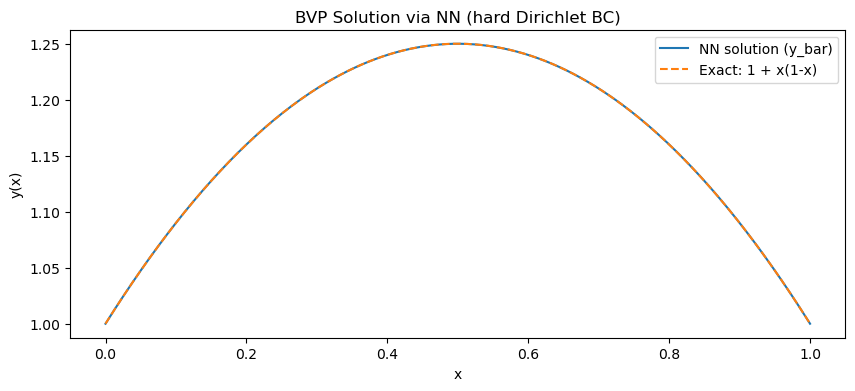

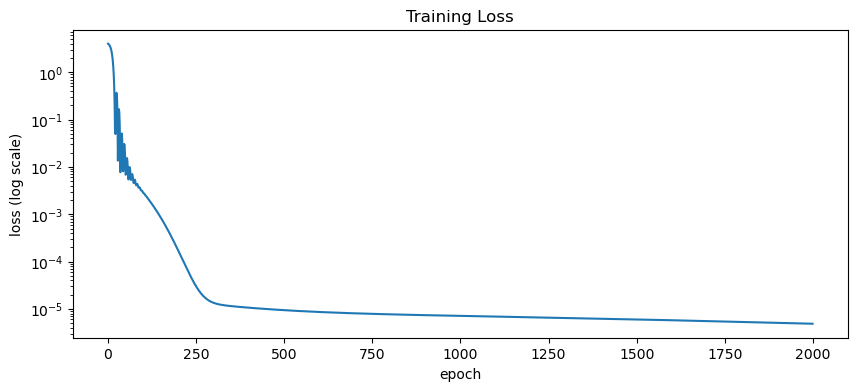

y_bar(0) approx = 1.0  | target = 1.0
y_bar(1) approx = 1.0  | target = 1.0


In [3]:
# evaluation grid
x_plot = torch.linspace(a, b, 400, device=device).view(-1, 1)
x_plot.requires_grad_(True)

with torch.no_grad():
    y_pred = y_bar(x_plot).cpu().numpy().reshape(-1)

x_np = x_plot.detach().cpu().numpy().reshape(-1)
y_true = 1 + x_np * (1 - x_np)  # exact solution for comparison

# plot solution
plt.figure(figsize=(10, 4))
plt.plot(x_np, y_pred, label="NN solution (y_bar)")
plt.plot(x_np, y_true, "--", label="Exact: 1 + x(1-x)")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend()
plt.title("BVP Solution via NN (hard Dirichlet BC)")

# plot loss
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss (log scale)")
plt.title("Training Loss")
plt.show()

# boundary check
print("y_bar(0) approx =", float(y_pred[0]), " | target =", y0)
print("y_bar(1) approx =", float(y_pred[-1]), " | target =", y1)
